# Analyze Eye Tracker Data

## Preliminaries

For parsing and converting the pupilometry data, we will use the recent fork of `python_eyelinkparser` module.
The dataset comes from {cite:p}`mathot_pupillometry_2018` and represents the eye response to a working-memory task on digits, following the classical work {cite:p}`kahneman_pupil_1966`. The original data was captured using `EyeLink 1000` by `SR Research`.

In [5]:
# install the fixed repo (fork)
!pip install --upgrade setuptools
!pip install git+https://github.com/maciejskorski/python-eyelinkparser.git 
# download and convert the data
import pkg_resources
edf2asc_path = pkg_resources.resource_filename('python_eyelinkparser', "utils/edf2ascii")
!mkdir data
!wget -O data/awm.edf https://github.com/smathot/pupillometry_review/blob/master/data/auditory%20working%20memory/data/awm.edf?raw=true
!{edf2asc_path} data/awm.edf -Y
!rm data/awm.edf 

  Cloning https://github.com/maciejskorski/python-eyelinkparser.git to /tmp/pip-req-build-ilp9dn_6
  Running command git clone --filter=blob:none --quiet https://github.com/maciejskorski/python-eyelinkparser.git /tmp/pip-req-build-ilp9dn_6
  Resolved https://github.com/maciejskorski/python-eyelinkparser.git to commit b0829b7a4d9a0d294f982516ec1143a88a8670db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
--2022-08-07 20:14:08--  https://github.com/smathot/pupillometry_review/blob/master/data/auditory%20working%20memory/data/awm.edf?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/smathot/pupillometry_review/raw/master/data/auditory%20working%20memory/data/awm.edf [following]
--2022-08-07 20:14:08--  ht

## Parse into Tabular Format

The converted data comes in the `asc` format which is essentially semi-structured text. 

To parse it, we use the package functions: interpolation for blinks is enabled, and the recording is downsampled by the factor of 10, from 1000 to 100Hz.

In [6]:
from datamatrix import (
  operations as ops,
  functional as fnc,
  series as srs
)
from python_eyelinkparser.eyelinkparser import parse, defaulttraceprocessor

def get_data():

    # The heavy lifting is done by eyelinkparser.parse()
    dm = parse(
        folder='data',           # Folder with .asc files 
        traceprocessor=defaulttraceprocessor(
          blinkreconstruct=True, # Interpolate pupil size during blinks
          downsample=10,         # Reduce sampling rate to 100 Hz,
          mode='advanced'        # Use the new 'advanced' algorithm
        )
    )
    # To save memory, we keep only a subset of relevant columns.
    dm = dm[dm.set_size, dm.correct, dm.ptrace_sounds, dm.ptrace_retention, 
            dm.fixxlist_retention, dm.fixylist_retention]
    return dm

dm = get_data()
print(dm)

..

/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/python_eyelinkparser/eyelinkparser/_events.py:166: UserWarning: Unexpected exception during parsing of list index out of range
  warnings.warn(


.........

/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/datamatrix/series.py:1476: RuntimeWarning: Mean of empty slice
  return fnc(a.reshape(-1, by), axis=1)


................................................................
EDF2ASC: EyeLink EDF file -> ASCII (text) file translator
EDF2ASC version 4.2.1.0 Linux   standalone Jun 18 2021 
(c)1995-2021 by SR Research, last modified Jun 18 2021

processing file data/awm.edf 
loadEvents = 1
=========================Preamble of file data/awm.edf=========================
| DATE: Wed Jan 24 05:57:43 2018                                              |
| TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED                                   |
| VERSION: EYELINK II 1                                                       |
| SOURCE: EYELINK CL                                                          |
| EYELINK II CL v4.56 Aug 18 2010                                             |
| CAMERA: EyeLink CL Version 1.4 Sensor=BGE                                   |
| SERIAL NUMBER: CL1-ABE24                                                    |
| CAMERA_CONFIG: ABE24140.SCD                                                 |


/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/python_eyelinkparser/eyelinkparser/_events.py:166: UserWarning: Unexpected exception during parsing of list index out of range
  warnings.warn(


.........

/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/datamatrix/series.py:1476: RuntimeWarning: Mean of empty slice
  return fnc(a.reshape(-1, by), axis=1)


................................................................+----+---------+---------------------------+---------------------------+-----------------------------------+-----------------------------------+----------+
| #  | correct |     fixxlist_retention    |     fixylist_retention    |          ptrace_retention         |           ptrace_sounds           | set_size |
+----+---------+---------------------------+---------------------------+-----------------------------------+-----------------------------------+----------+
| 0  |    1    | [525.9 527.1 ... nan nan] | [382.9 380.4 ... nan nan] | [1810.  1810.3 ... 1902.9 1908.2] |    [1655.6 1657.1 ... nan nan]    |    5     |
| 1  |    1    | [528.9 526.8 ... nan nan] | [386.4 387.5 ... nan nan] | [1644.6 1648.7 ... 1675.4 1673.4] |    [1717.3 1718.5 ... nan nan]    |    3     |
| 2  |    1    | [521.4 524.2 ... nan nan] | [377.3 371.4 ... nan nan] | [1787.  1791.4 ... 1719.9 1719.3] | [1471.8 1470.4 ... 1783.2 1785.3] |    7     |


## Visualize

The baseline correction is applied, with first 2 samples as the baseline. The time is clipped at 1200 which corresponds to 12s (1000Hz in the original recording was downsampled 10x).

In [7]:
dm.pupil = srs.concatenate(
    srs.endlock(dm.ptrace_sounds),
    dm.ptrace_retention
)
dm.pupil = srs.baseline(
    series=dm.pupil,
    baseline=dm.ptrace_sounds,
    bl_start=0,
    bl_end=2
)
dm.pupil.depth = 1200

/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/datamatrix/_datamatrix/_seriescolumn.py:130: RuntimeWarning: Mean of empty slice
  return nanmean(self._seq, axis=0)


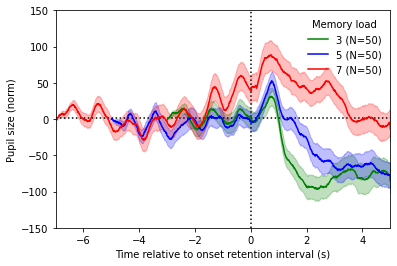

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def plot_series(x, s, color, label):

    se = s.std / np.sqrt(len(s))
    plt.fill_between(x, s.mean-se, s.mean+se, color=color, alpha=.25)
    plt.plot(x, s.mean, color=color, label=label)


x = np.linspace(-7, 5, 1200)
dm3, dm5, dm7 = ops.split(dm.set_size, 3, 5, 7)

plt.figure()
plt.xlim(-7, 5)
plt.ylim(-150, 150)
plt.axvline(0, linestyle=':', color='black')
plt.axhline(1, linestyle=':', color='black')
plot_series(x, dm3.pupil, color='green', label='3 (N=%d)' % len(dm3))
plot_series(x, dm5.pupil, color='blue', label='5 (N=%d)' % len(dm5))
plot_series(x, dm7.pupil, color='red', label='7 (N=%d)' % len(dm7))
plt.ylabel('Pupil size (norm)')
plt.xlabel('Time relative to onset retention interval (s)')
plt.legend(frameon=False, title='Memory load')
plt.show()

# References

```{bibliography}
```